# TP2 - MCMC

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres (disponible dans le premier notebook). Le deuxième exercice met en oeuvre une méthode de régression bayésienne linéaire.

### Instructions

1. Renommer votre notebook sous la forme `tp2b_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 10 Décembre 2023, 23h59.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss
from sklearn import datasets
import random

### Partie 2 - Régression linéaire bayésienne parcimonieuse

On suppose le modèle de régression linéaire suivant :
$$ y_i \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)$$

On a :
* $y \in \mathbb{R}$, la variable que l'on cherche à prédire ;
* $\mathbf{x}_i \in \mathbb{R}^p$, les features ;
* $\boldsymbol{\beta} \in \mathbb{R}^p$, le vecteur de régression ;
* $\sigma^2$ la variance du bruit.

Nous adoptons une approche bayésienne. Les paramètres du modèle, $\boldsymbol{\beta}$ et $\sigma^2$, doivent donc être munis d'une loi a priori.

Dans cet exercice, nous allons suivre le modèle du *Bayesian LASSO* ([Park et al. (2008)](https://people.eecs.berkeley.edu/~jordan/courses/260-spring09/other-readings/park-casella.pdf)).

Le LASSO est une méthode de régression pénalisée classique (c'est la pénalisation en norme $\ell_1$ - vous connaissez la pénalisation en norme $\ell_2$ appelée *ridge regression*). Nous regardons ici sa version bayésienne. Les lois a priori sont les suivantes :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\beta_p | \sigma^2 & \sim \text{Laplace} \left( 0, \frac{\sqrt{\sigma^2}}{\lambda} \right)
\end{align}

$\lambda$ est le paramètre de régularisation. Il se trouve qu'en prenant une loi a priori de [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) pour les coefficients de régression, le problème du LASSO est le même que celui l'estimation MAP.

À partir des données $\mathcal{D} = \{ (\mathbf{x}_1, y_1), ... (\mathbf{x}_n, y_n) \}$, l'objectif est donc de caractériser la loi a posteriori $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$. Elle n'est pas tractable analytiquement. Nous allons donc échantillonner de cette loi à l'aide d'un algorithme MCMC, plus précisémment, un [échantillonneur de Gibbs](https://fr.wikipedia.org/wiki/%C3%89chantillonnage_de_Gibbs).

Il n'est pas possible de dériver un échantillonneur de Gibbs immédiatement. Il se trouve que le modèle peut être ré-écrit de la manière suivante :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\tau_i^2 & \sim \text{Exp} \left( \frac{\lambda^2}{2} \right) \\
\beta_j | \tau_j^2, \sigma^2 & \sim \mathcal{N}(0, \sigma^2 \tau_j^2) \\
y_i | \boldsymbol{\beta}, \sigma^2 & \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)
\end{align}

On peut alors trouver les lois conditionnelles :
\begin{align}
\boldsymbol{\beta} | \boldsymbol{\tau}, \sigma^2, \mathcal{D} \sim \mathcal{N}(\mathbf{A} \mathbf{X}^{\top} \mathbf{y}, \sigma^2 \mathbf{A}),
\end{align}
avec $\mathbf{A} = (\mathbf{X}^{\top} \mathbf{X} + \mathbf{D}_{\tau})^{-1}$, où $\mathbf{D}_{\tau} = \text{diag}(\tau_1^{-2}, ..., \tau_p^{-2})$.
\begin{align}
\tau_j^{-2} | \boldsymbol{\beta}, \sigma^2, \mathcal{D} \sim \text{InvGaussian}\left( \sqrt{\frac{\lambda^2 \sigma^2}{\beta_j^2}}, \lambda^2 \right),
\end{align}
(Loi "Inverse-Gaussian" -> [ici](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution))
\begin{align}
\sigma^2 | \boldsymbol{\beta}, \boldsymbol{\tau}, \mathcal{D} \sim \text{IG}\left( a_0 + \frac{n+p}{2}, b_0 + \frac{1}{2} || \mathbf{y - X} \boldsymbol{\beta} ||^2_2 + \frac{1}{2} \sum_{j=1}^p \frac{\beta_j^2}{\tau_j^2} \right)
\end{align}

In [2]:
# Pre-processing the data

# Load the dataset
diabetes = datasets.load_diabetes()

# Print dataset description
print(diabetes.DESCR)

# Features
X = diabetes.data
X = X/np.std(X, axis = 0) # Standardize
N,P = X.shape

# Target
y = diabetes.target
y = (y-np.mean(y))/np.std(y) # Standardize

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

**Q1.** Écrire une fonction implémentant l'échantillonnage de Gibbs dans ce modèle, qui prend en arguments :
* Les données sous forme matricielle $\mathbf{X}$ et $\mathbf{y}$
* Le nombre d'échantillons $N_g$
* La taille du *burn-in* $N_b$
* Les hyper-paramètres du modèle : $a_0, b_0, \lambda$

Elle retourne $N_g$ échantillons du posterior $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$.

**Attention !** Bien lire la doc. de `scipy.stats.invgauss` pour savoir quels paramètres utiliser.

In [3]:
def bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l):
    beta_values = []
    sigma_2_values = []
    sigma_2 =  ss.invgamma.rvs(a=a0, scale = b0)
    tau0 = np.random.exponential(scale=2/l**2, size=X.shape[1])
    tau_inv = tau0**(-1)

    for i in range(Ng+Nb):
        A = np.linalg.inv(X.transpose()@X + np.diag(tau_inv))
        
        beta = np.random.multivariate_normal(mean=A@X.transpose()@y, cov=sigma_2*A)
        tau_inv = [ss.invgauss.pdf(x=np.sqrt(l**2*sigma_2/beta[j]**2), mu= l**2) for j in range(len(beta))] 
        sigma_2 = ss.invgamma.rvs(a= a0 + (X.shape[0] +X.shape[1])/2, scale= b0 + 1/2*np.linalg.norm(y-X@beta)**2 + 1/2*np.dot(beta.transpose()**2,tau_inv))
        if i >=Nb:
            beta_values.append(beta)
            sigma_2_values.append(sigma_2)

    return beta_values, sigma_2_values


**Q2.** Faire tourner la chaîne MCMC avec les paramètres suivants : $N_g = N_b = 1000$, $a_0 = b_0 = 1$, $\lambda = 10$.

* Afficher le *traceplot* pour un paramètre de votre choix. Commenter.
* Pour chacun des paramètres $\boldsymbol{\beta}$ et $\sigma^2$, afficher un histogramme ou un KDE des $N_g$ échantillons obtenus. Afficher sur le même plot la valeur de l'estimation MMSE et MAP. Enfin, donner l'intervalle de crédibilité à 95%. (Cf. dernier chapitre du cours Intro à l'Estimation)

In [4]:
Ng = 1000
Nb = 1000
a0 = 1
b0 = 1
l = 10

beta_values, sigma_2_values = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l)

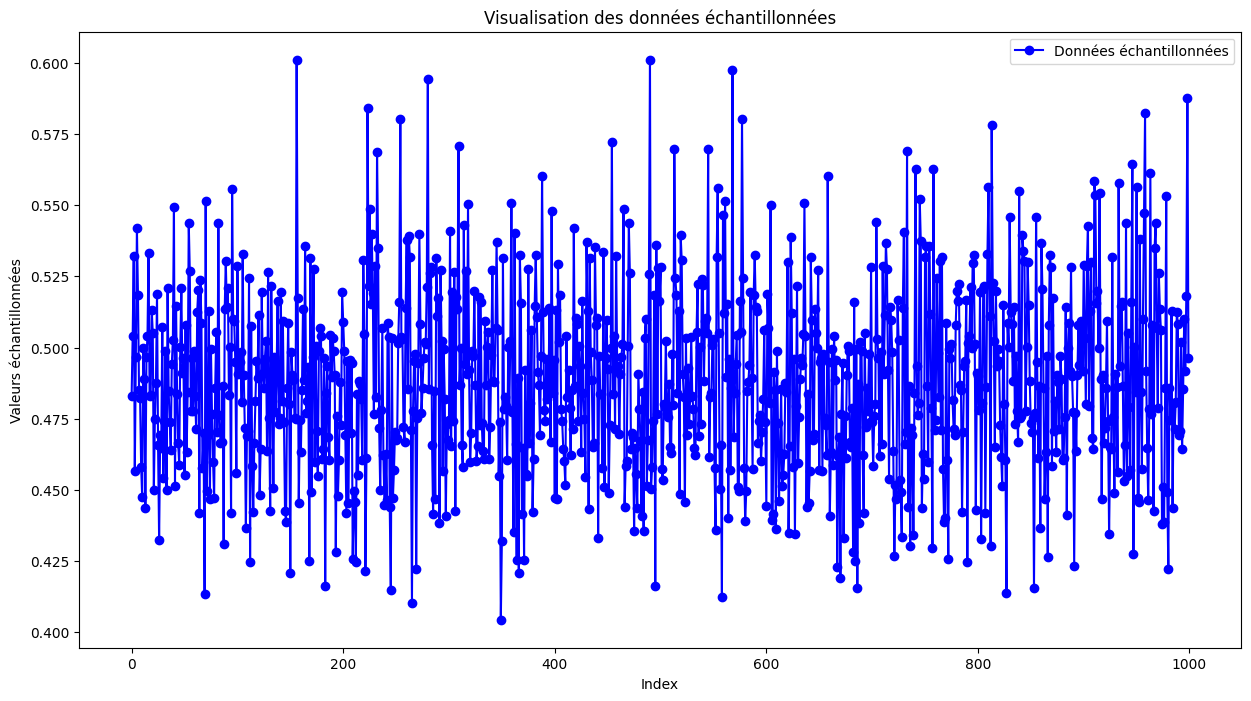

In [5]:
plt.figure(figsize=(15,8))
plt.plot(range(len(sigma_2_values)), sigma_2_values, linestyle='-', marker='o', color='blue', label='Données échantillonnées')

plt.xlabel('Index')
plt.ylabel('Valeurs échantillonnées')
plt.title('Visualisation des données échantillonnées')
plt.legend()

plt.show()

On observe que la chaine de markov change fréquement de valeurs (pas de plateaux) et les échantillons atteignent l'ensemble du support de la loi inverse gamma

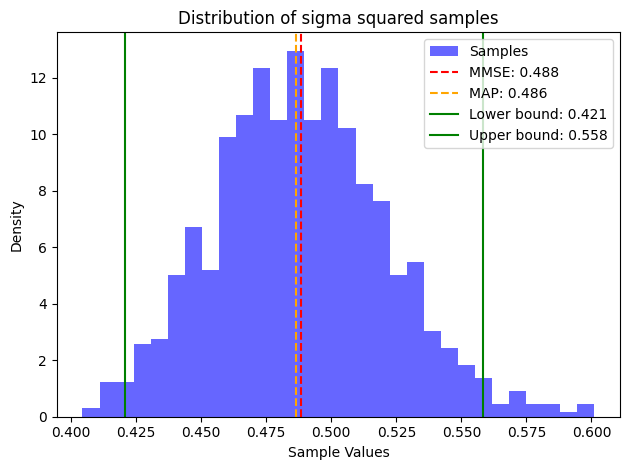

In [6]:
plt.plot(figsize=(12, 8))

values, bins, _ = plt.hist(sigma_2_values, bins=30, density=True, alpha=0.6, color='blue', label=f'Samples')
plt.axvline(x=np.mean(sigma_2_values), color='red', linestyle='--', label=f'MMSE: {np.mean(sigma_2_values):.3f}')
# Calculer le centre du bin avec la fréquence la plus élevée
index_max_freq = values.argmax()
map = (bins[index_max_freq] + bins[index_max_freq + 1]) / 2
plt.axvline(x=map, color='orange', linestyle='--', label=f'MAP: {map:.3f}')

bound = values.sum()*0.025
i = 0
cumulative=values[i]
while cumulative<= bound:
    i+=1
    cumulative+= values[i]

j = len(values)-1
cumulative = values[j]
while cumulative<= bound:
    j-=1
    cumulative += values[j]

lower_IC = (bins[i-1] + bins[i]) / 2
upper_IC = (bins[j+1] + bins[j]) / 2

plt.axvline(x=lower_IC, color='g', linestyle='-', label=f'Lower bound: {lower_IC:.3f}')
plt.axvline(x=upper_IC, color='g', linestyle='-', label=f'Upper bound: {upper_IC:.3f}')

plt.xlabel('Sample Values')
plt.ylabel('Density')
plt.title(f'Distribution of sigma squared samples')
plt.legend()

plt.tight_layout()
plt.show()


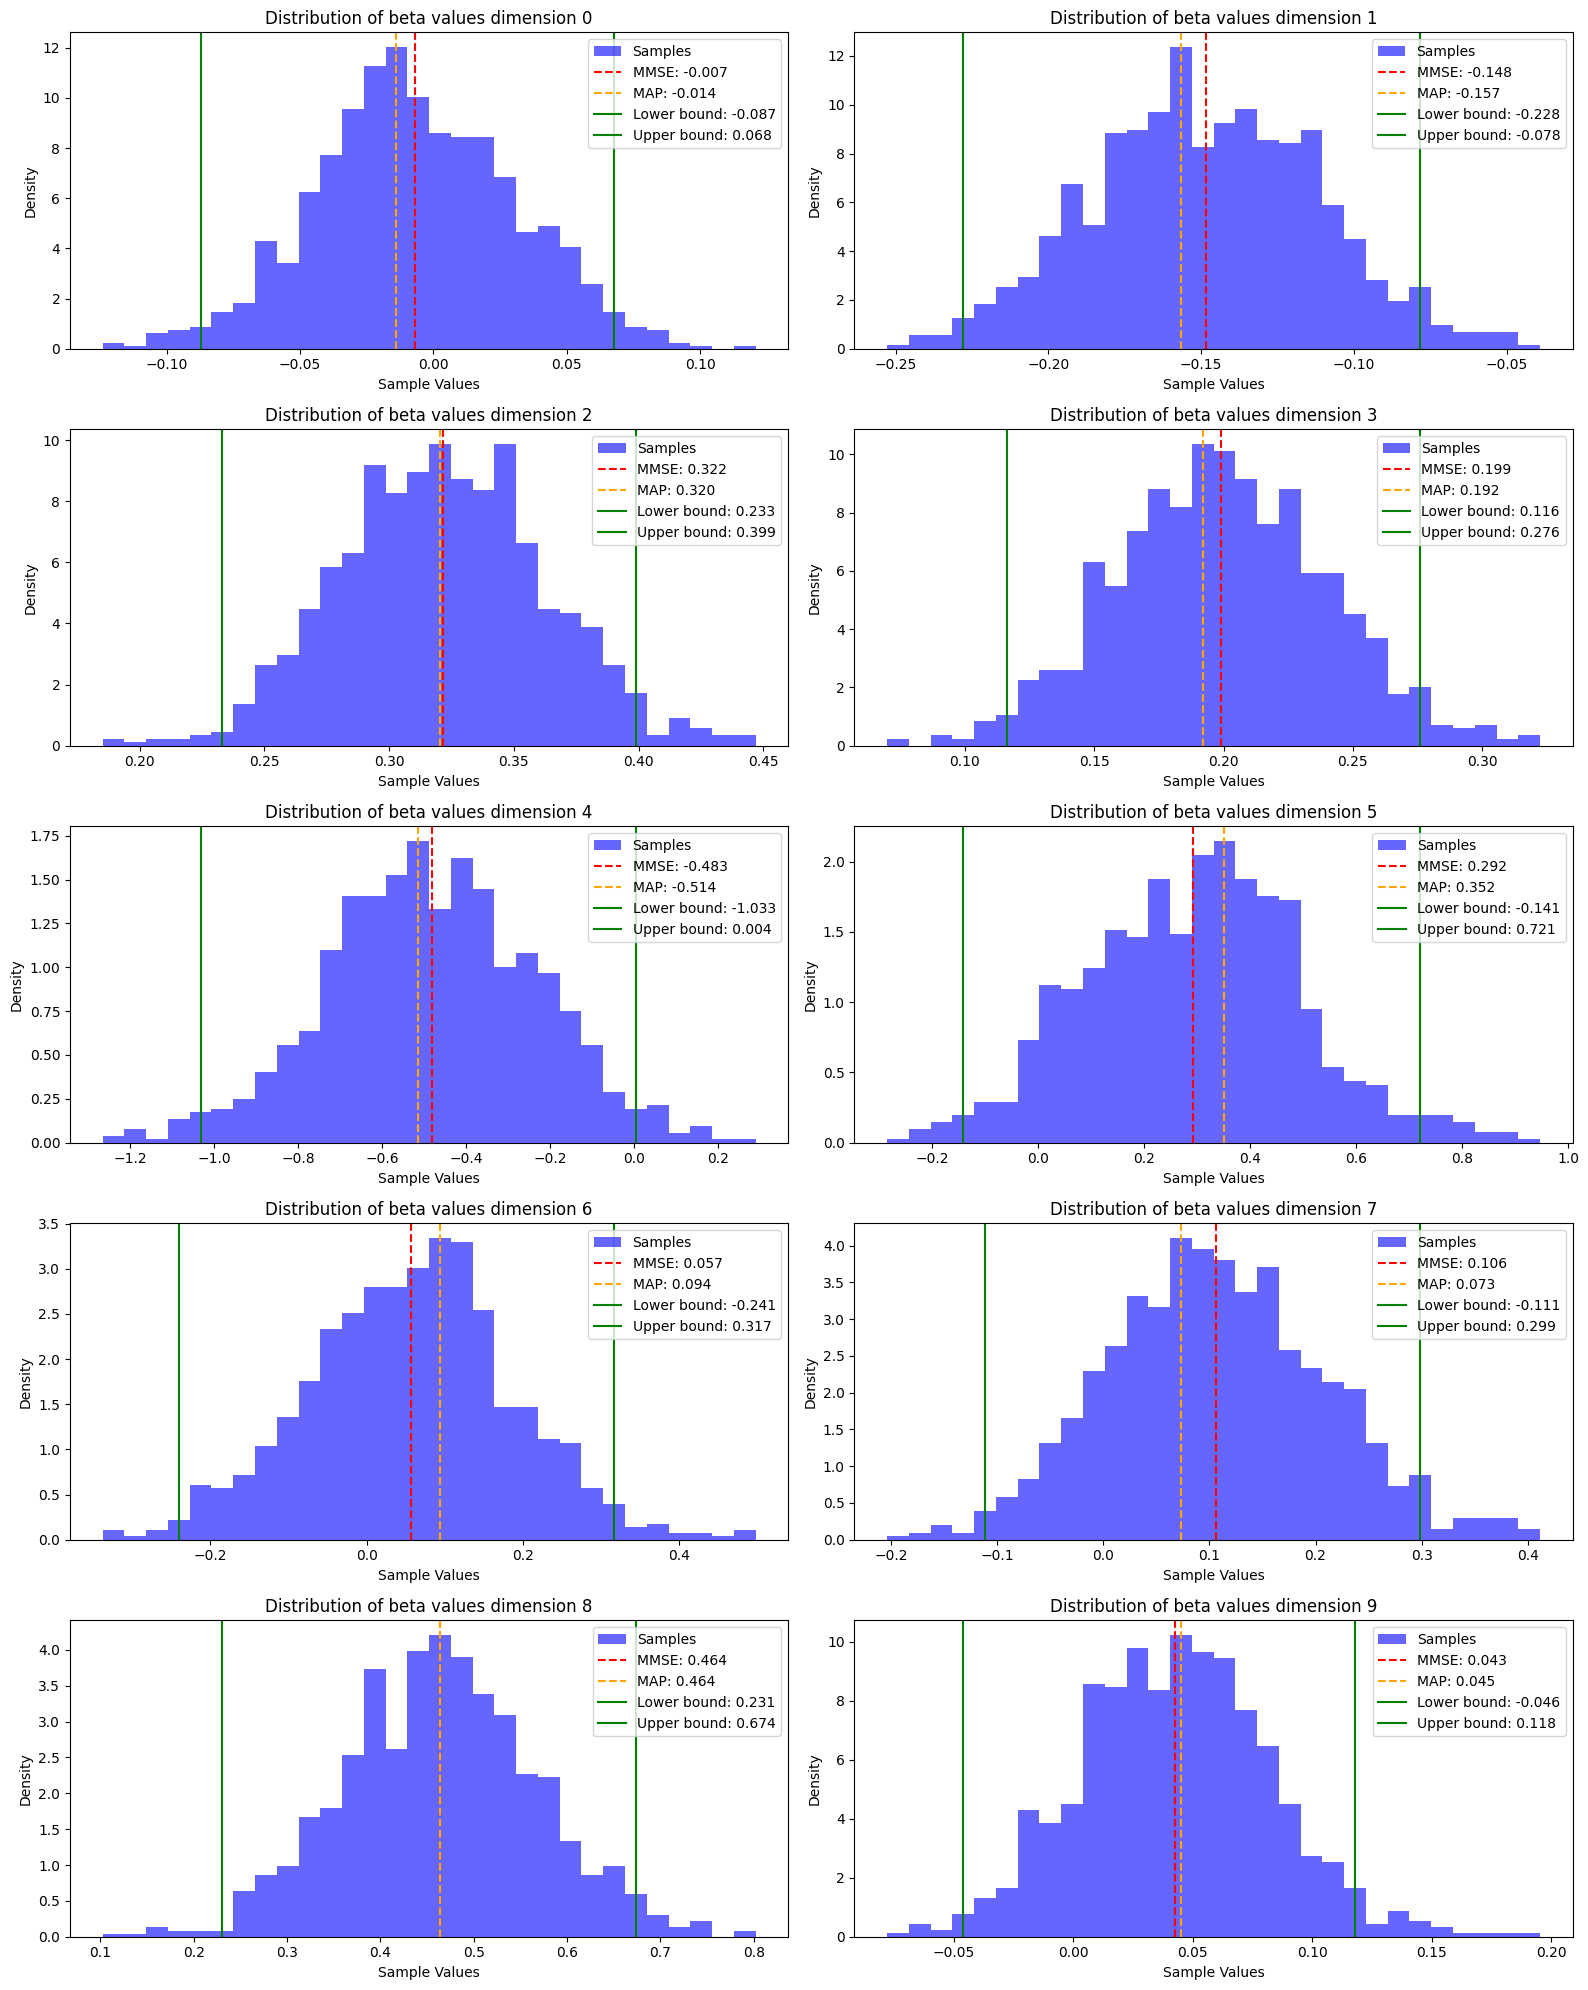

In [19]:
fig, axs = plt.subplots(5, 2, figsize=(16, 20))

for l in range(10):
    
    # Tracer l'histogramme pour beta_values
    ax = axs[l//2, l%2]
    values, bins, _ = ax.hist(np.array(beta_values)[:,l], bins=30, density=True, alpha=0.6, color='blue', label='Samples')
    
    # Calcul des statistiques - MMSE, MAP, intervalles de confiance
    mean = np.mean(np.array(beta_values)[:,l])
    ax.axvline(x=mean, color='red', linestyle='--', label=f'MMSE: {mean:.3f}')
    
    index_max_freq = values.argmax()
    map_val = (bins[index_max_freq] + bins[index_max_freq + 1]) / 2
    ax.axvline(x=map_val, color='orange', linestyle='--', label=f'MAP: {map_val:.3f}')
    
    bound = values.sum() * 0.025
    i = 0
    cumulative = values[i]
    while cumulative <= bound:
        i += 1
        cumulative += values[i]

    j = len(values) - 1
    cumulative = values[j]
    while cumulative <= bound:
        j -= 1
        cumulative += values[j]

    lower_IC = (bins[i - 1] + bins[i]) / 2
    upper_IC = (bins[j + 1] + bins[j]) / 2
    
    ax.axvline(x=lower_IC, color='g', linestyle='-', label=f'Lower bound: {lower_IC:.3f}')
    ax.axvline(x=upper_IC, color='g', linestyle='-', label=f'Upper bound: {upper_IC:.3f}')
    
    ax.set_xlabel('Sample Values')
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of beta values dimension {l}')
    ax.legend()

plt.tight_layout()
plt.show()


On observe bien des gaussiennes, la loi de 
\begin{align}
\boldsymbol{\beta} | \boldsymbol{\tau}, \sigma^2, \mathcal{D} \sim \mathcal{N}(\mathbf{A} \mathbf{X}^{\top} \mathbf{y}, \sigma^2 \mathbf{A}),
\end{align}
suit donc bien une loi normal multivarié comme attendu

**Q3.** Générer 1000 échantillons de la loi prédictive a posteriori pour le nouveau point $x_{\text{new}}$ (défini dans le code) et tracer un histogramme ou un KDE. Commenter.

In [8]:
x_new = np.array([ 1.41145807,  1.06548848,  0.30006161,  0.45984057, -0.52475728,
       -1.70643289,  1.02259953,  1.49710409, -1.25030999,  0.84817082])
y_new_list = []
for _ in range(1000):
    sigma_2 = random.choice(sigma_2_values)
    tau_2 = np.random.exponential(scale=2/l**2, size=X.shape[1])
    beta = [np.random.normal(0,np.sqrt(sigma_2*tauj_2)) for tauj_2 in tau_2]

    ynew = np.random.normal(x_new@beta,np.sqrt(sigma_2)) 
    y_new_list.append(ynew)

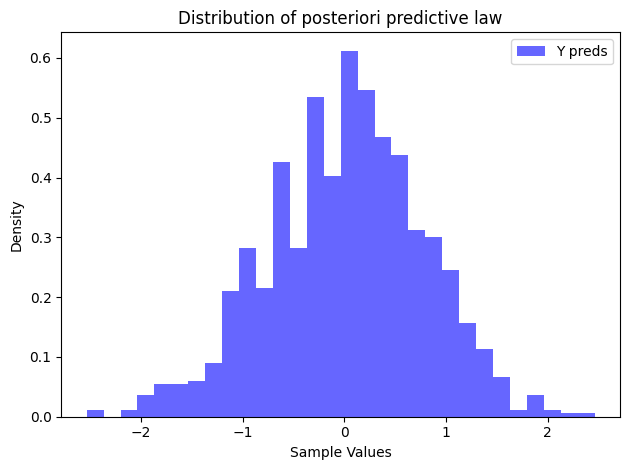

In [11]:
plt.plot(figsize=(12, 8))

plt.hist(y_new_list, bins=30, density=True, alpha=0.6, color='blue', label=f'Y preds')
plt.xlabel('Sample Values')
plt.ylabel('Density')
plt.title(f'Distribution of posteriori predictive law')
plt.legend()

plt.tight_layout()
plt.show()


**Q4.** Étudier l'influence du paramètre lambda sur l'inférence des paramètres.

Sans l'implémenter, à l'aide de vos connaissances, pouvez-vous proposer une méthode permettant de choisir lambda ?

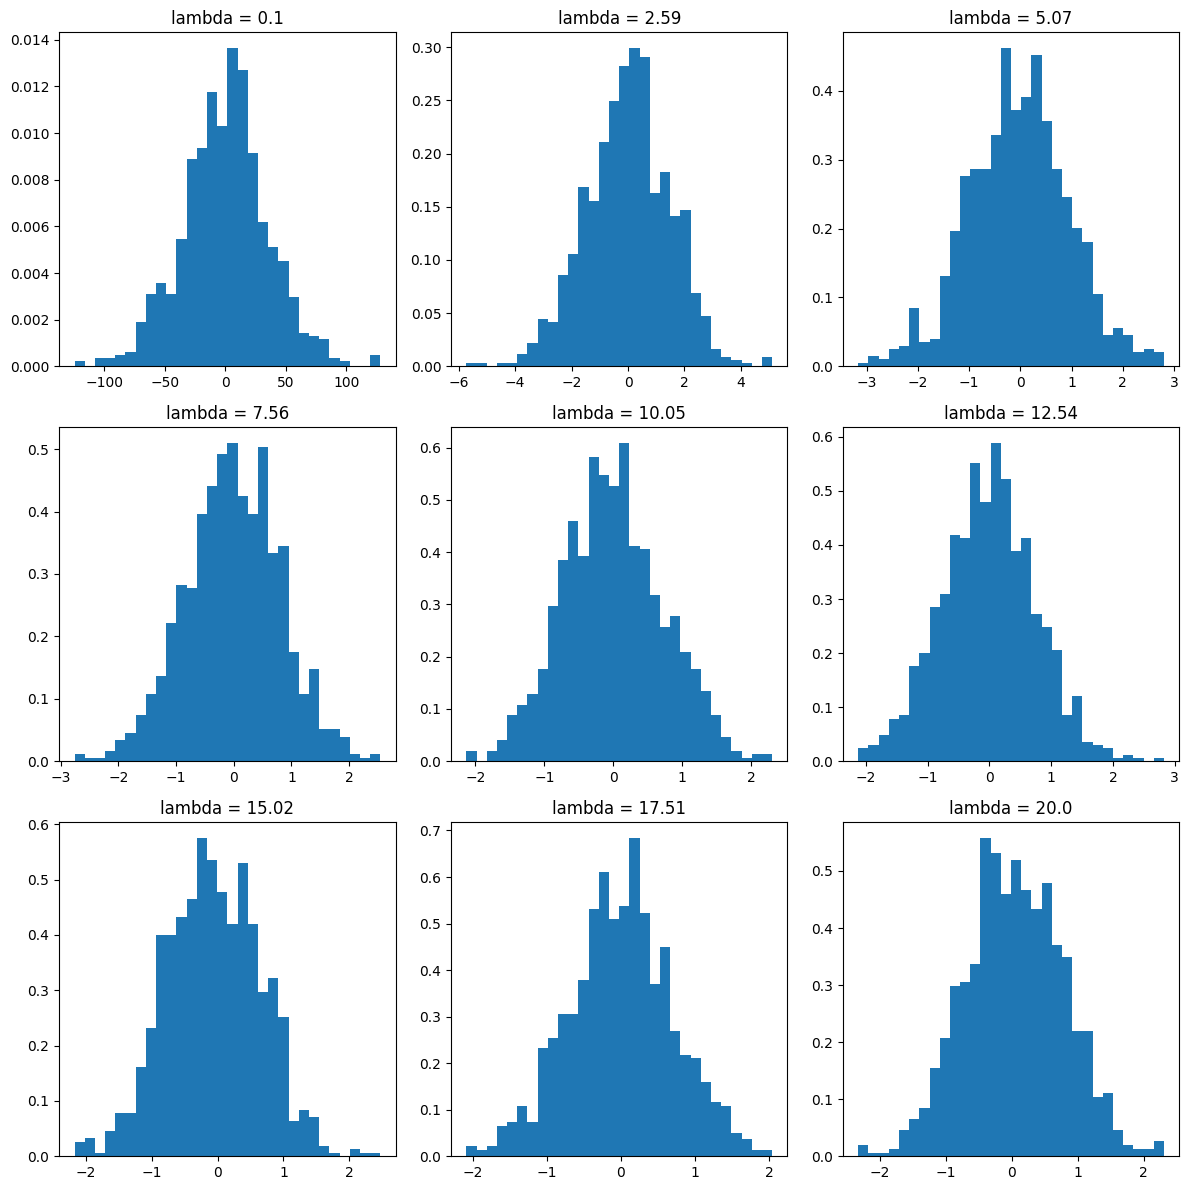

In [17]:

l_values = np.linspace(0.1, 20, 9)

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, l in enumerate(l_values):
    y_new_list = []
    for _ in range(1000):
        sigma_2 = random.choice(sigma_2_values)
        tau_2 = np.random.exponential(scale=2/l**2, size=X.shape[1])
        beta = [np.random.normal(0,np.sqrt(sigma_2*tauj_2)) for tauj_2 in tau_2]

        ynew = np.random.normal(x_new@beta,np.sqrt(sigma_2)) 
        y_new_list.append(ynew)

    row = i // 3
    col = i % 3
    axs[row, col].hist(y_new_list, bins=30, density = True)
    axs[row, col].set_title(f"lambda = {np.round(l,2)}")

# Ajustements des marges et des espacements entre les sous-graphiques
plt.tight_layout()
plt.show()


Pour des valeurs faible de lambda, le support de la densité est beaucoup plus large, à partir de lambda = 10 on observe peux de changements pour la distribution.

En écrivant la likelihood $ f(X | \lambda) $ grace aux différentes loi conditionnelles on pourrait determiner le maximum de vraissemblance pour déterminer la valeur de lambda la plus pertinente au vu de la distribution X observée. Ou alors déterminer l'estimateur MAP ie la valeur de lambda qui maximise la distribution $ \lambda | X $

**Questions bonus**. Le TP est déjà long. Votre objectif premier est d'effectuer les questions précédentes correctement.

S'il vous reste du temps et de la motivation, voici deux questions "papier-crayon" :
* Montrer que l'estimation MAP dans un modèle avec un *prior* Laplace pour les coefficients de régression mène bien au même problème que le LASSO
* Dériver la loi conditionnelle pour $\boldsymbol{\beta}$ ou $\sigma^2$. Attention ! Le calcul de la loi conditionnelle de $\tau_i$ est quant à lui très compliqué. Ne le tentez pas sans l'aide d'un(e) professionnel(le).